In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_20DLorenz.recursive_Markovian_PostMeanScore_20DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [9]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


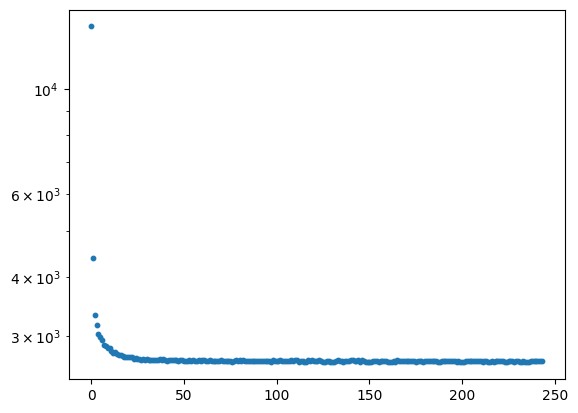

243

In [4]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

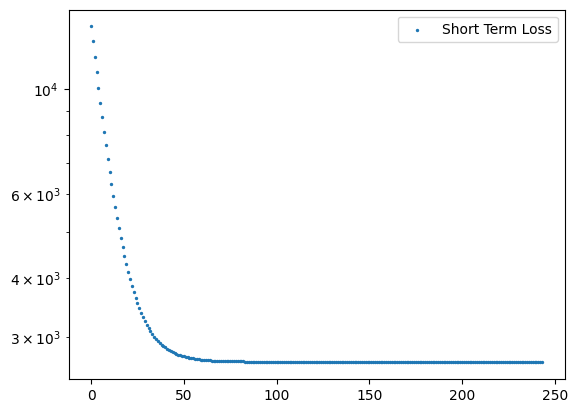

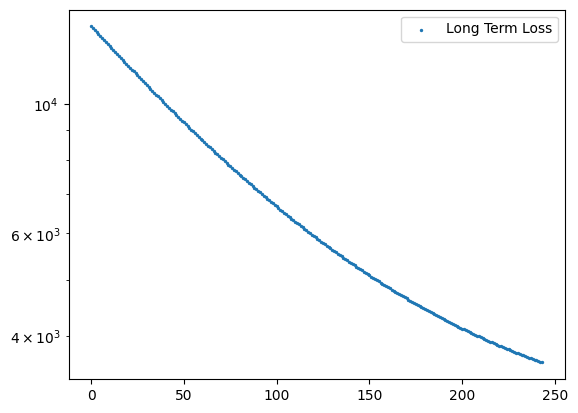

In [5]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

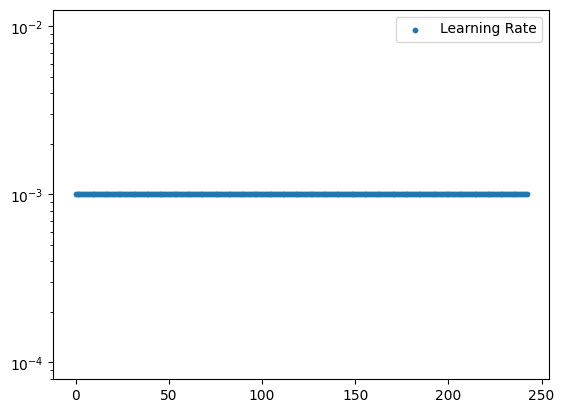

0


In [6]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(end-start+1)

In [7]:
def get_drift_files(config, root_dir):
    ts_type = f"ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz".replace(".", "")
    include =  (f"_{1}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/12DLnz/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "MLP_" in file and ts_type in file and include in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "global" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [8]:
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config,root_dir=root_dir)
len(Nepochs_track)

298

In [9]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_1587/4063213029.py:11: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_1587/4063213029.py:12: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


{1: 68.98778435547631,
 2: 12.833657108499544,
 4: 9.06971655101982,
 6: 6.071027257846024,
 8: 6.77484993750363,
 10: 3.8166581342311887,
 12: 5.5468936560916315,
 14: 4.037819048670811,
 16: 5.307671409074847,
 18: 4.391600243644435,
 20: 5.277874252007195,
 22: 4.632683099775165,
 24: 5.874550369365849,
 26: 5.784461543922785,
 28: 5.9916981747677776,
 30: 5.326575021002954,
 32: 6.334316121990372,
 34: 4.961497108634805,
 36: 6.937448322580835,
 38: 4.199150285516609,
 40: 6.8797172312078425,
 42: 4.582151828863876,
 44: 6.943329627348974,
 46: 4.324761786623173,
 48: 6.2047424869689545,
 50: 4.22276285541821,
 52: 6.660891354531136,
 54: 4.028884346193573,
 56: 6.651307894518907,
 58: 4.207441833439069,
 60: 6.983188336013024,
 62: 4.122135712526166,
 64: 6.733985588985994,
 66: 4.051776943626596,
 68: 6.746166952366445,
 70: 4.455977800894977,
 72: 6.566962132484543,
 74: 4.17161009122376,
 76: 6.222242311872722,
 78: 4.402722824642956,
 80: 6.487176635186543,
 82: 4.162876982660

In [10]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])

In [11]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(1, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == np.array(list(drift_track_rmses.keys())))[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

In [12]:
print(common_epochs)

[  1   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242]


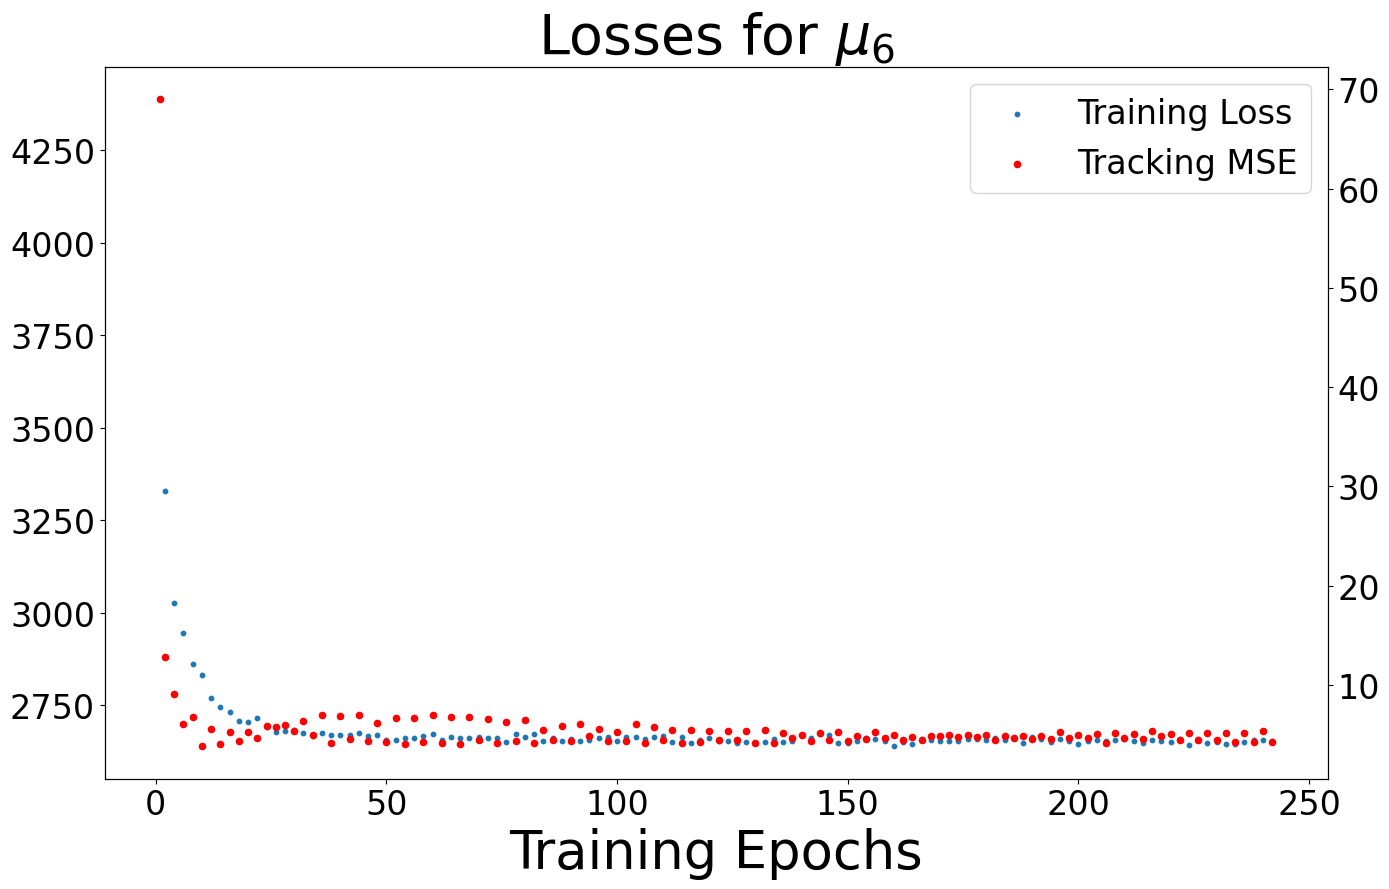

In [13]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
ax.set_title(r"Losses for $\mu_{6}$", fontsize=40)

#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/12DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_{config.forcing_const}FConst_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

(2, 100, 257, 12)


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_1587/1856219619.py:17: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_1587/1856219619.py:18: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


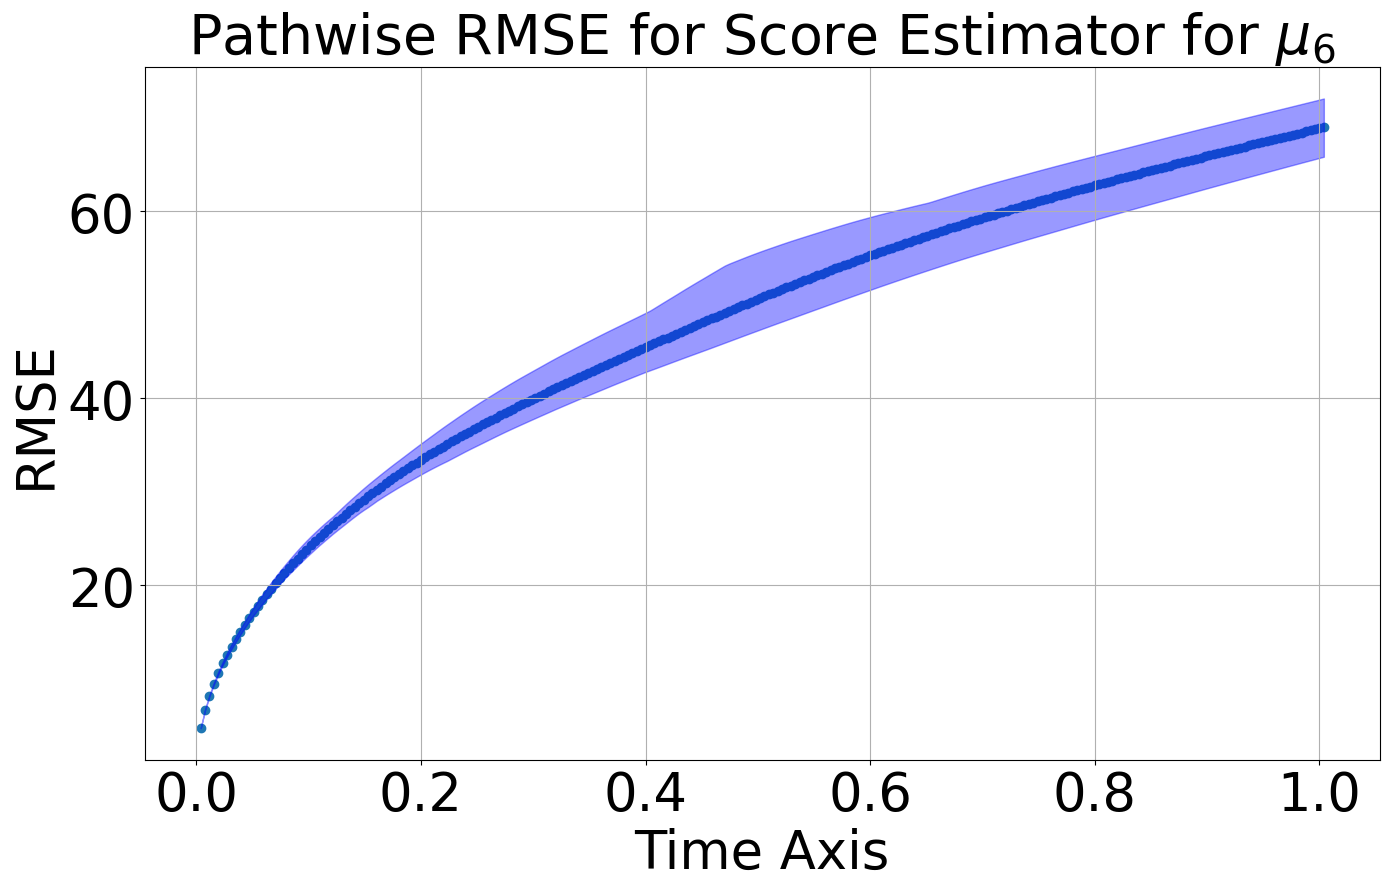

Final time cumulative MSE local-time error 68.98778435547631 with final IQR (65.8288724933281, 72.05705015127111) at Nepoch 1 for 0.75FConst

(2, 100, 257, 12)


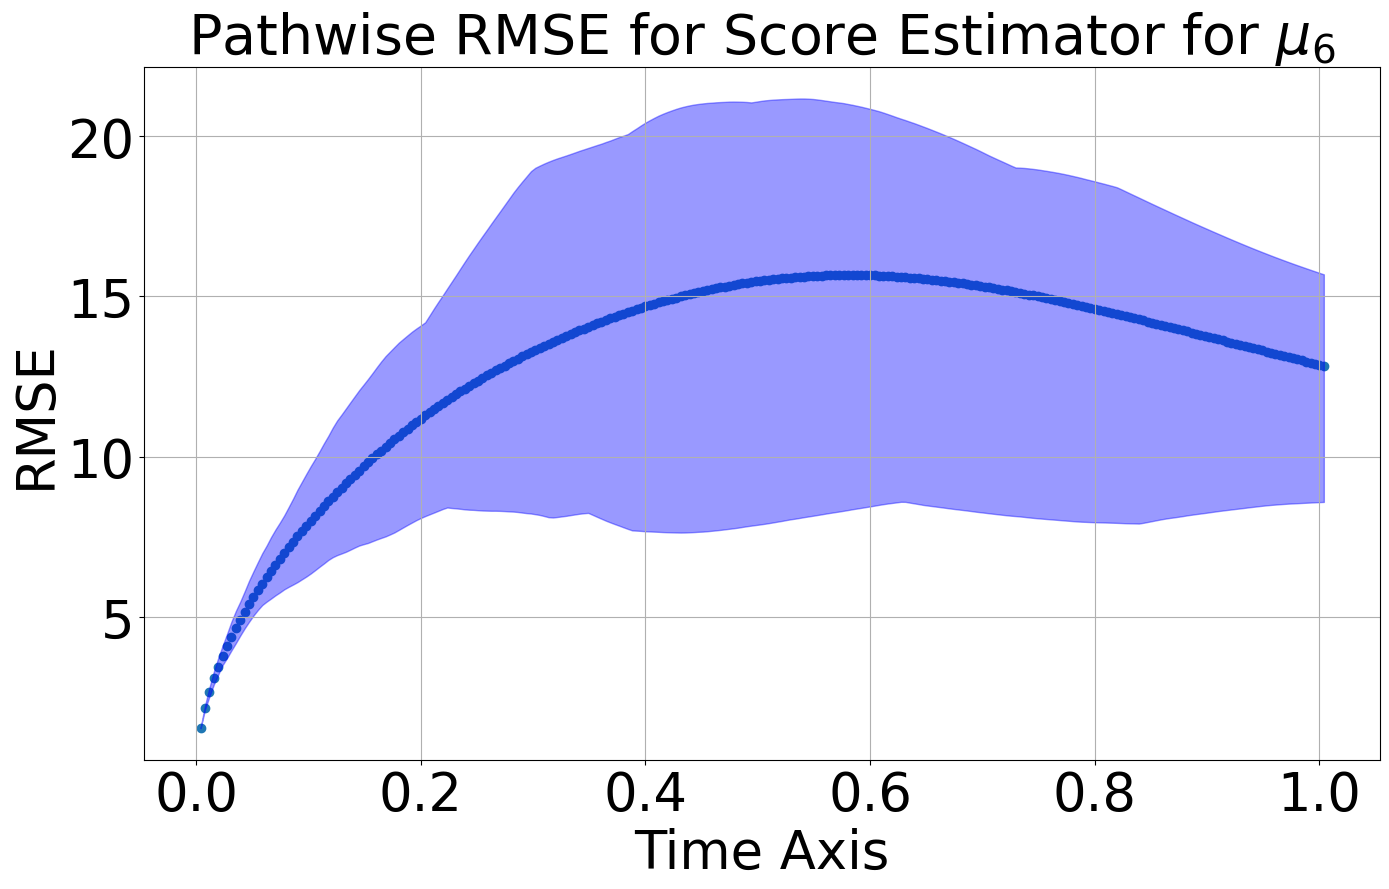

Final time cumulative MSE local-time error 12.833657108499544 with final IQR (8.591680934615809, 15.687934214295439) at Nepoch 2 for 0.75FConst

(2, 100, 257, 12)


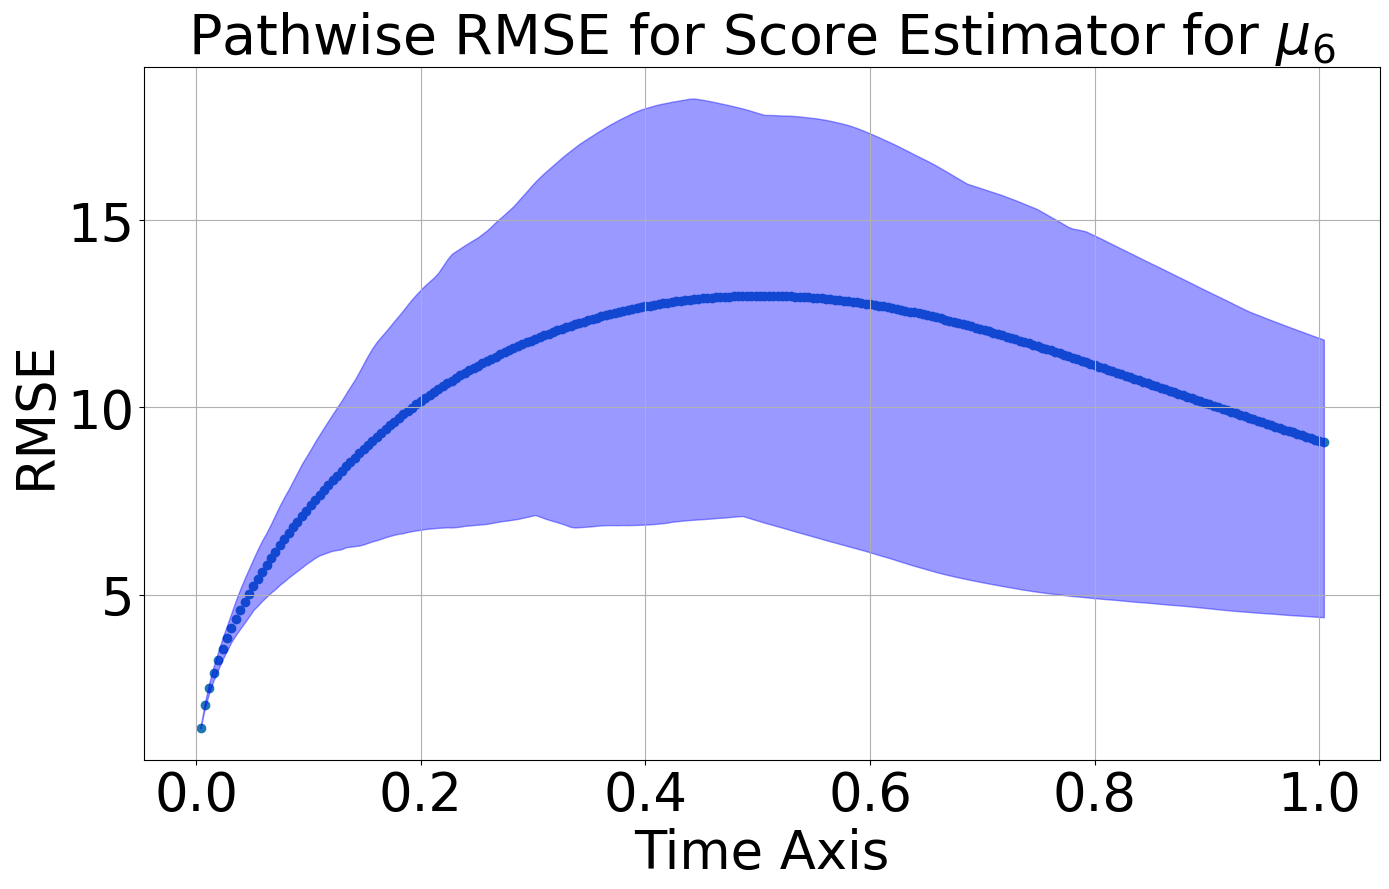

Final time cumulative MSE local-time error 9.06971655101982 with final IQR (4.400282600965403, 11.812314581803305) at Nepoch 4 for 0.75FConst

(2, 100, 257, 12)


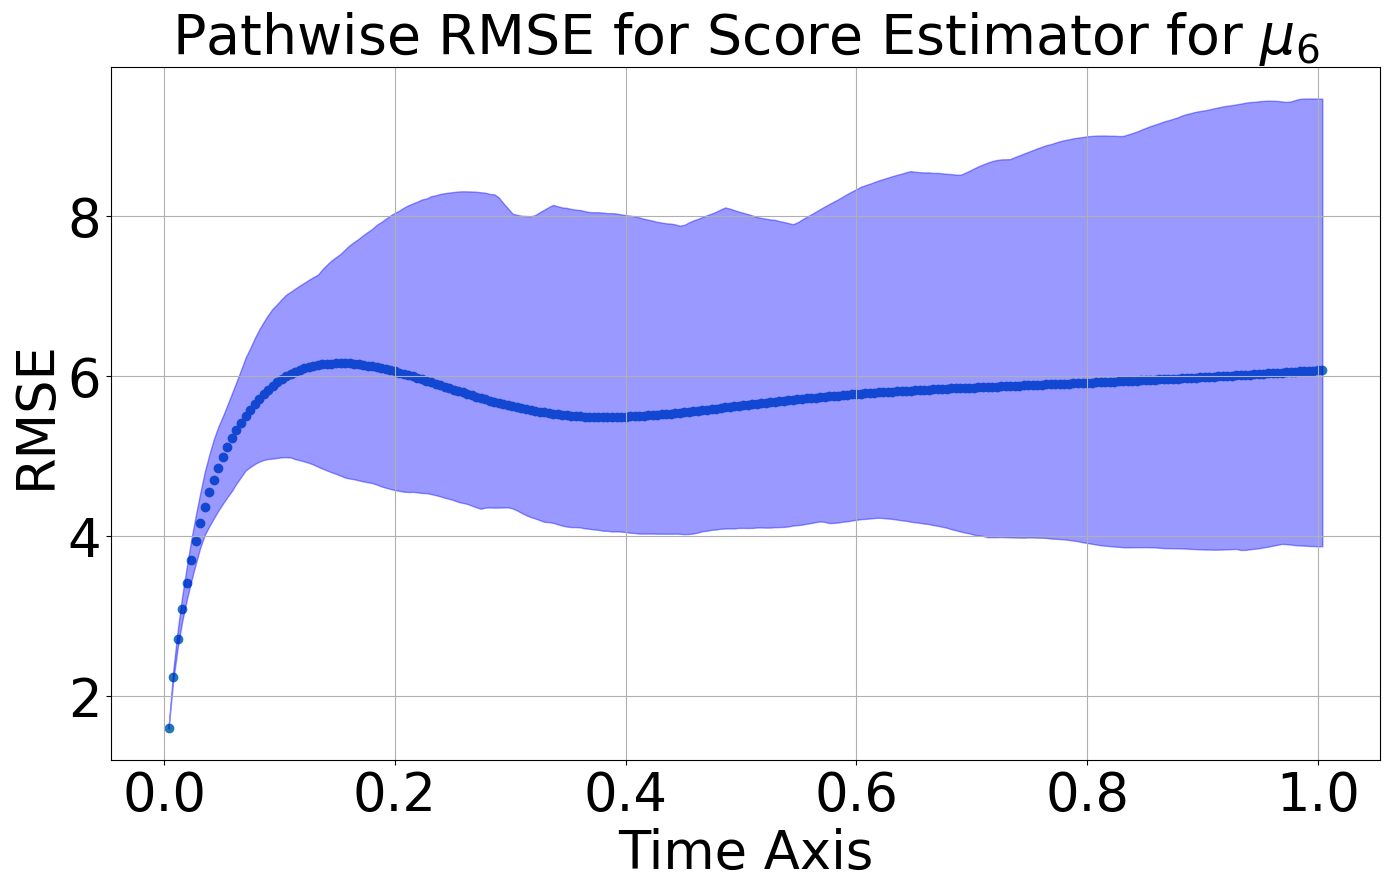

Final time cumulative MSE local-time error 6.071027257846024 with final IQR (3.866040869679112, 9.461885472475727) at Nepoch 6 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)


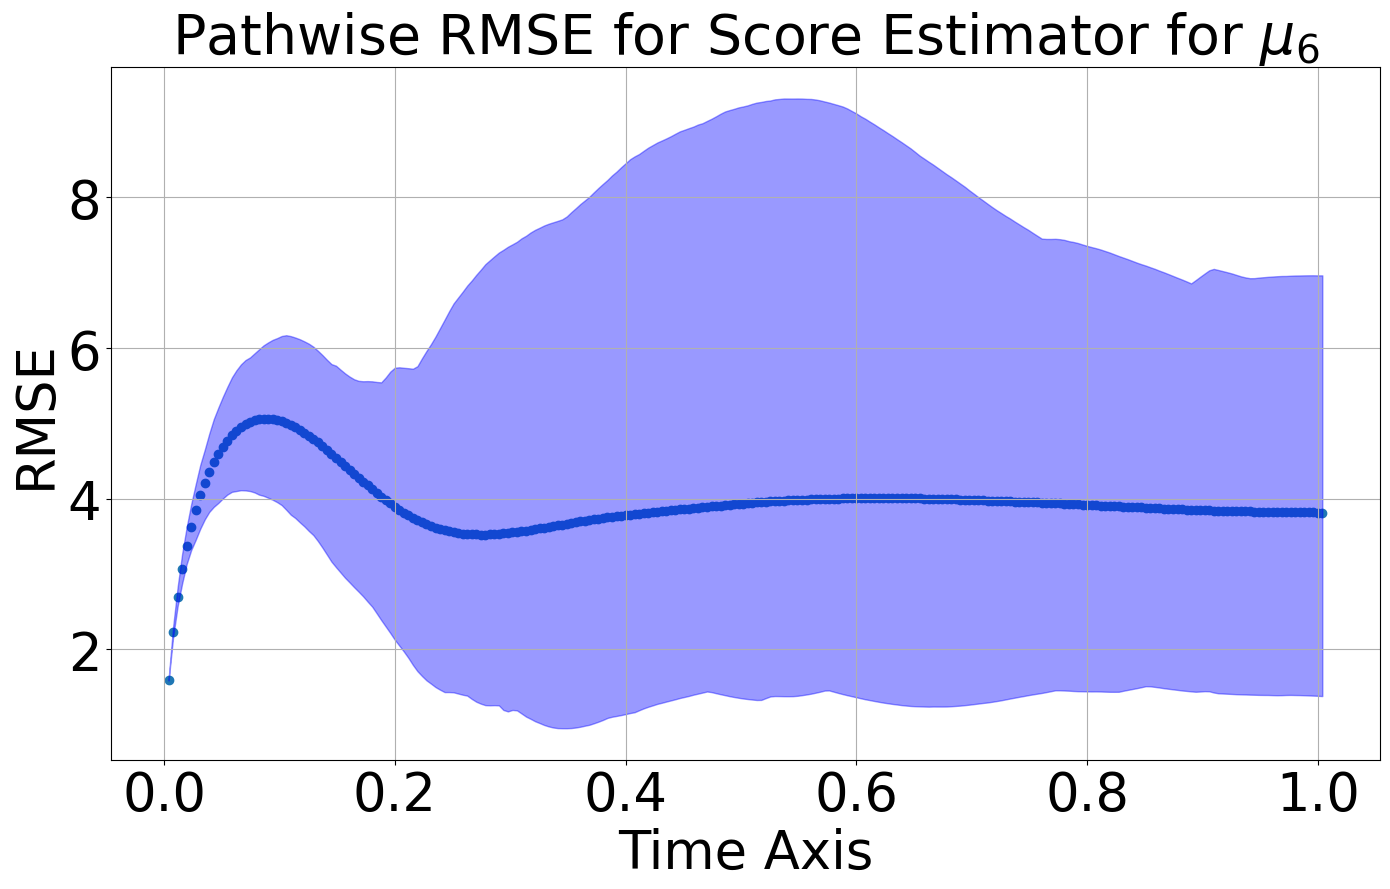

Final time cumulative MSE local-time error 3.8166581342311887 with final IQR (1.3807176422027747, 6.965933063817539) at Nepoch 10 for 0.75FConst

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100,

In [14]:
curr_rmse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        if Nepoch < 1: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        print(all_local_states.shape)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Score Estimator for $\mu_6$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/12DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_DriftTrack_{Nepoch}Nep_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue
# 0.021385787 final time error for 12DLnz at epoch 94 before changing final_tau = init_tau = 1.

In [15]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
import torch
scoreModel1 = ConditionalMarkovianTSPostMeanScoreMatching(
        *config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/"
modelname = config.scoreNet_trained_path.replace(rootdir, "")
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel1.load_state_dict(torch.load(rootdir+file))
        print(file)
tau1 =  max(scoreModel1.mlp_state_mapper.hybrid.final_tau,
                          scoreModel1.mlp_state_mapper.hybrid.init_tau * (0.9 ** (94 // 20)))
scoreModel1.eval()
scoreModel2 = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters)
rootdir = "/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/snapshots/"
for file in os.listdir(rootdir):
    if modelname in file:
        scoreModel2.load_state_dict(torch.load(rootdir+file, map_location=torch.device("cpu"))["MODEL_STATE"])
scoreModel2.eval()
tau2 =  max(scoreModel2.mlp_state_mapper.hybrid.final_tau,
                          scoreModel2.mlp_state_mapper.hybrid.init_tau * (0.9 ** (Nepochs_losses[-1] // 20)))
print(tau1, tau2)

trained_rec_PM_ST_0010FTh_MLP_2LFac_12DLnz_750e-01FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110_NEp164


ModuleNotFoundError: No module named 'numpy._core'

In [ ]:
import torch

# Loop through named parameters
for (name_5, param_5), (name_20, param_20) in zip(scoreModel1.named_parameters(), scoreModel2.named_parameters()):
    assert name_5 == name_20  # Sanity check: same parameter names

    # Compute L2 norm of difference
    diff = torch.norm(param_5.data - param_20.data).item()
    print(f"{name_5}: L2 norm difference = {diff:.6f}")


In [ ]:
torch.mean(torch.exp(scoreModel2.mlp_state_mapper.hybrid.log_scale)), torch.mean(torch.sigmoid(scoreModel2.mlp_state_mapper.hybrid.gate_logits / 0.5)), scoreModel2.mlp_state_mapper.hybrid.tau

In [ ]:
Nepoch_good = 170000
Nepoch_bad = 300
good_idx = np.argwhere(common_epochs == Nepoch_good)[0,0]
bad_idx = np.argwhere(common_epochs == Nepoch_bad)[0,0]
good_true = np.load(drift_true_files[good_idx])[0, :, :, :]
good_local = np.load(drift_local_files[good_idx])[0, :,:, :]
bad_true = np.load(drift_true_files[bad_idx])[0, :, :, :]
bad_local = np.load(drift_local_files[bad_idx])[0, :, :,:]
print(bad_local.shape, bad_true.shape)
B, T, D = bad_local.shape

In [ ]:
for dim in range(config.ndims):
    dim_idx = dim + 1
    time_ax = np.linspace(config.t0,config.deltaT*T,T)
    # Print different "true sample paths"
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for _ in range(B):
        axes[0].scatter(time_ax, good_true[_, :, dim]-good_local[_, :, dim], color="red", s=1)
        axes[1].scatter(time_ax, bad_true[_, :, dim]-bad_local[_, :, dim], color="blue", s=1)
    plt.suptitle(f"True vs Score-Based Path Difference for Dimension {dim_idx}\n")
    plt.xlabel("Time")
    plt.ylabel("Path")
    plt.show()
    plt.close()

In [10]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching

scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(*config.model_parameters)
training_size = int(sum(p.numel() for p in scoreModel.parameters() if p.requires_grad))

In [11]:
training_size

23405